In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
#get path and image_ids

from glob import glob
import os

#training images
path_to_train = '../input/train/train'
glob_train_imgs = os.path.join(path_to_train, '*.jpg')
train_img_paths = glob(glob_train_imgs)
print (train_img_paths[:10])

#testing images
path_to_test = '../input/test/test'
glob_test_imgs = os.path.join(path_to_test, '*.jpg')
test_img_paths = glob(glob_test_imgs)
print (test_img_paths[:10])

def get_img_basename(img_path):
    img_basename = os.path.basename(img_path)
    #img_id = os.path.splitext(img_basename) #os.path.splittext splits on period
    return img_basename

def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0]
    return img_id

path = '../input/train/train/655c71d8c3f3d61f3797545e7d0414ce.jpg'

print (get_img_basename(path))

['../input/train/train/028192187883168e2a7621c998dc447a.jpg', '../input/train/train/95d2e16da6d3fb55b84f83f25a7dcf2e.jpg', '../input/train/train/03fe79948e15465c62c400ad9d9fab13.jpg', '../input/train/train/f5fc5cebc8bf22c70240fd42bd3d64e8.jpg', '../input/train/train/d8d2f5becda9d56dadf2d64339395807.jpg', '../input/train/train/39118ef96763296fdaac19b5445781ac.jpg', '../input/train/train/5c5e5b595cd88af108eed5b9d5f3e0e6.jpg', '../input/train/train/f8738a9ee535240bd178101fe12fb3ba.jpg', '../input/train/train/c745412c3abc0bad208dcae6d0ab4e2f.jpg', '../input/train/train/28118684e8726a7c503d45d6cc9aeb87.jpg']
['../input/test/test/c662bde123f0f83b3caae0ffda237a93.jpg', '../input/test/test/9553eed7793d4cf88b5226d446d93dae.jpg', '../input/test/test/19f059a7ce41b25be1548bc4049b45ec.jpg', '../input/test/test/fb4f464486f4894330273346ce939252.jpg', '../input/test/test/b52558a522db6ec2501ae188b6d6e526.jpg', '../input/test/test/d91989075ade0ecab01c9b5cae1c00d3.jpg', '../input/test/test/e6083ba00ecd6c

In [3]:
#get classification (cactus/no cactus for each image id
train = pd.read_csv('../input/train.csv')
#print (train)
#A = train[train['id']  == '655c71d8c3f3d61f3797545e7d0414ce.jpg']
#print (A['has_cactus'].values[0])

def get_class(img_path):
    img_basename = get_img_basename(img_path)
    A = train[train['id']  == img_basename]
    label = A['has_cactus'].values[0]
    return label
    

def image_gen(img_paths, img_size=(32, 32)):
# Iterate over all the image paths
    for img_path in img_paths:
        #print (img_path)
        label = get_class(img_path)
        #Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) 
        #Resize the images
        #print (img.shape)
        img = resize(img, img_size, preserve_range=True)        
        #Yield the image, label pair
        yield img, label


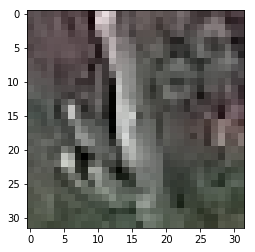

1


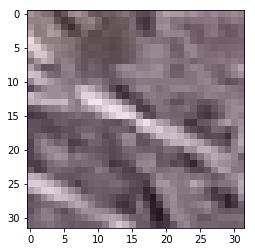

1


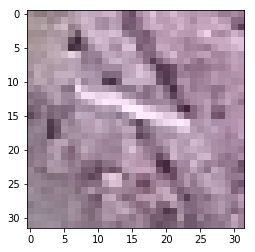

1


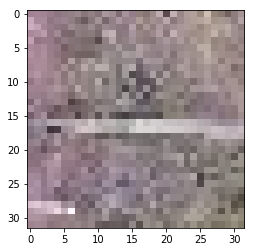

1


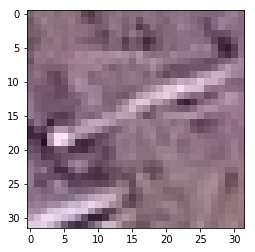

1


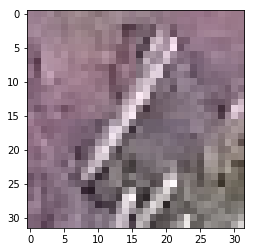

1


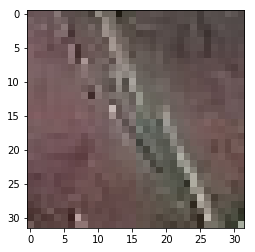

1


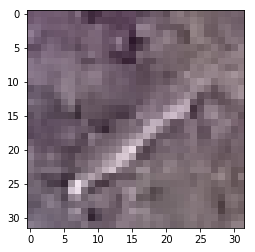

1


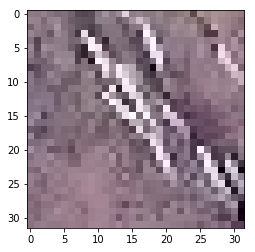

1


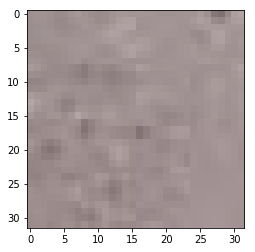

0


In [11]:
#plot a few images 
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tensorflow import keras

ig = image_gen(train_img_paths) #create generator object

for i in range(10):
    first_img, first_label = next(ig)
    plt.imshow(first_img/255)
    plt.show()
    print (first_label)


In [4]:
#image augmentation
%matplotlib inline
import collections
import mxnet as mx # used version '1.0.0' at time of writing
from mxnet.gluon.data import dataset
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

def horizontal_augmentation(img):
    aug = mx.image.HorizontalFlipAug(1)
    img = mx.nd.array(img)
    aug_img = aug(img)
    return aug_img.asnumpy()

def vertical_augmentation(img):  
    img = np.flipud(img)   
    return img
      
def rotate_augmentation(img):
    new_img = np.rot90(img)
    return new_img
    
def brightness_augmentation(img): #changes brightness
    aug = mx.image.BrightnessJitterAug(brightness=.5)
    img = mx.nd.array(img)
    aug_img = aug(img)
    # Add more color augmentations here...
    aug_img = aug_img.astype('int')
    return aug_img.asnumpy()


In [ ]:
import matplotlib.pyplot as plt

original = imread(train_img_paths[10])
img_id = get_img_id(train_img_paths[10])

aug = brightness_augmentation(original)
print ('Original')
plt.imshow(original/255)
plt.show()
print ('Brightness Augmentation')
plt.imshow(aug/255)
plt.show()
print ('Rotation')
img = rotate_augmentation(original)
plt.imshow(img/255)
plt.show()
print ('Horizontal Flip')
img = horizontal_augmentation(original)
plt.imshow(img/255)
plt.show()
print ('Vertical Flip')
img = vertical_augmentation(original)
plt.imshow(img/255)
plt.show()


In [6]:
#model
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Reshape
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout,MaxPooling2D
from keras.models import Sequential
from keras.layers import Layer, ZeroPadding2D, UpSampling2D
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [ ]:
#this doesn't work very well...
def segnet_mod():

    kernel = 3
    pad = 1
    pool_size = 2

    model = Sequential()
    model.add(Layer(input_shape=(32, 32 ,3)))

    # encoder
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(64, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(128, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(256, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(512, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))


    # decoder
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(512, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(256, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(128, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(64, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())
    
    #add fully connected layers below for binary classification
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

In [9]:
import numpy as np

def image_batch_generator(img_paths, set_type, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_label = [], []
        
        for img, label in ig:
            # Add the image and label to the batch
            if set_type == 'train':
                vertical = vertical_augmentation(img)
                vertical = (vertical - vertical.mean())/vertical.std() 
                batch_img.append(vertical)
                batch_label.append(label)
            img = (img - img.mean())/img.std()  #0-1 standardize each image individually 
            batch_img.append(img)
            batch_label.append(label)
            #print (len(batch_img))
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_label, axis=0)
                batch_img, batch_label = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_label, axis=0)
            batch_img, batch_label = [], []  

In [ ]:
#check if GPU is really there
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

In [12]:
#train model

from sklearn.model_selection import train_test_split

BATCHSIZE = 32

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.10)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths,'val', batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, 'val', batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)  #multiply by 2 because you augmented it 
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs = 20, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=1  # Change this number based on memory restrictions
)

Epoch 1/20
204/399 [==============>...............] - ETA: 53s - loss: 0.1637 - acc: 0.9341

KeyboardInterrupt: 

In [ ]:
#generate predictions
import time 

def generate_predictions_generator(val_paths):
    for img_path in val_paths: 
        img = imread(img_path)
        img_id = get_img_basename(img_path)
        img = (img - img.mean())/img.std()  
        y = model.predict(img.reshape(1,32,32,3))  
        #print (y)
        yield img_id, y

def create_submission(csv_name, predictions_gen):
    sub = pd.DataFrame()
    ids = []
    encodings = []
    num_images = len(test_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        img_id, pred = next(predictions_gen)
        ids.append(img_id)
        encodings.append(pred[0][0])
    
    sub['id'] = ids
    sub['has_cactus'] = encodings
    sub.to_csv(csv_name, index=False)
    #print (encodings)
        
        
#create submission
tic = time.time()
create_submission("cactus.csv", generate_predictions_generator(test_img_paths))
toc = time.time()
print(toc - tic)
